In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

from xgboost import XGBClassifier, plot_tree, plot_importance

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

# Classifiers
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

pd.options.display.float_format = "{:,.2f}".format

In [2]:
df = pd.read_csv("data01.csv")
df.head()

group      ID  outcome  age  gendera   BMI  hypertensive  \
0      1  125047     0.00   72        1 37.59             0   
1      1  139812     0.00   75        2   NaN             0   
2      1  109787     0.00   83        2 26.57             0   
3      1  130587     0.00   43        2 83.26             0   
4      1  138290     0.00   75        2 31.82             1   

   atrialfibrillation  CHD with no MI  diabetes  ...  Blood sodium  \
0                   0               0         1  ...        138.75   
1                   0               0         0  ...        138.89   
2                   0               0         0  ...        140.71   
3                   0               0         0  ...        138.50   
4                   0               0         0  ...        136.67   

   Blood calcium  Chloride  Anion gap  Magnesium ion   PH  Bicarbonate  \
0           7.46    109.17      13.17           2.62 7.23        21.17   
1           8.16     98.44      11.44           1.89 7.22        33.44   
2           8.27    105.86      10.00           2.16 7.27        30.57   
3           9.48     92.07      12.36           1.94 7.37        38.57   
4           8.73    104.50      15.17           1.65 7.25        22.00   

   Lactic acid  PCO2  EF  
0         0.50 40.00  55  
1         0.50 78.00  55  
2         0.50 71.50  35  
3         0.60 75.00  55  
4         0.60 50.00  55  

[5 rows x 51 columns]

# EDA

First, we find what is the shape of the data

In [3]:
# the data has 1177 rows and 51 columns
df.shape

(1177, 51)

Now, we'll check for any missing or NA values in the data

In [4]:
'''
There are almost 20% of missing values for some columns, 
removing them would make quite a big of loss of information
'''

df.isnull().sum()

group                         0
ID                            0
outcome                       1
age                           0
gendera                       0
BMI                         215
hypertensive                  0
atrialfibrillation            0
CHD with no MI                0
diabetes                      0
deficiencyanemias             0
depression                    0
Hyperlipemia                  0
Renal failure                 0
COPD                          0
heart rate                   13
Systolic blood pressure      16
Diastolic blood pressure     16
Respiratory rate             13
temperature                  19
SP O2                        13
Urine output                 36
hematocrit                    0
RBC                           0
MCH                           0
MCHC                          0
MCV                           0
RDW                           0
Leucocyte                     0
Platelets                     0
Neutrophils                 144
Basophil

In [5]:
# another way to check each column's data type and the available data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   group                     1177 non-null   int64  
 1   ID                        1177 non-null   int64  
 2   outcome                   1176 non-null   float64
 3   age                       1177 non-null   int64  
 4   gendera                   1177 non-null   int64  
 5   BMI                       962 non-null    float64
 6   hypertensive              1177 non-null   int64  
 7   atrialfibrillation        1177 non-null   int64  
 8   CHD with no MI            1177 non-null   int64  
 9   diabetes                  1177 non-null   int64  
 10  deficiencyanemias         1177 non-null   int64  
 11  depression                1177 non-null   int64  
 12  Hyperlipemia              1177 non-null   int64  
 13  Renal failure             1177 non-null   int64  
 14  COPD    

In [6]:
'''
It is found that there is one missing value in the outcome column, since it is the dependent variable,
I decided to drop that row. I also dropped the ID column since it does not make sense if a person's ID
impacts their mortality
'''
df = df.dropna(subset=['outcome'])
df = df.drop('ID', axis=1)

In [7]:
'''
categorical data in this dataset are the diseases related to the ICU patients (comorbidities)
numerical data in this dataset are the factors related to the ICU patients
to make sure the distinction is clear between those data, I classified numerical features
as features which have more than 5 unique values
'''

numerical_features = [features for features in df.columns if len(df[features].unique())>5]
categorical_features = [features for features in df.columns if features not in numerical_features]

In [8]:
# sanity check of the numerical features
numerical_features 

['age',
 'BMI',
 'heart rate',
 'Systolic blood pressure',
 'Diastolic blood pressure',
 'Respiratory rate',
 'temperature',
 'SP O2',
 'Urine output',
 'hematocrit',
 'RBC',
 'MCH',
 'MCHC',
 'MCV',
 'RDW',
 'Leucocyte',
 'Platelets',
 'Neutrophils',
 'Basophils',
 'Lymphocyte',
 'PT',
 'INR',
 'NT-proBNP',
 'Creatine kinase',
 'Creatinine',
 'Urea nitrogen',
 'glucose',
 'Blood potassium',
 'Blood sodium',
 'Blood calcium',
 'Chloride',
 'Anion gap',
 'Magnesium ion',
 'PH',
 'Bicarbonate',
 'Lactic acid',
 'PCO2',
 'EF']

In [9]:
# sanity check of the categorical features
categorical_features

['group',
 'outcome',
 'gendera',
 'hypertensive',
 'atrialfibrillation',
 'CHD with no MI',
 'diabetes',
 'deficiencyanemias',
 'depression',
 'Hyperlipemia',
 'Renal failure',
 'COPD']

In [10]:
'''
even though I initially classified categorical features as features with 5 or less distinct values,
it is found that each of them only indicates whether a person has the comorbidities and only has 
2 distinct values
'''
for col in categorical_features:
    print(f"{col} has {df[col].nunique()} unique values")

group has 2 unique values
outcome has 2 unique values
gendera has 2 unique values
hypertensive has 2 unique values
atrialfibrillation has 2 unique values
CHD with no MI has 2 unique values
diabetes has 2 unique values
deficiencyanemias has 2 unique values
depression has 2 unique values
Hyperlipemia has 2 unique values
Renal failure has 2 unique values
COPD has 2 unique values


There are a lot of independent variables (50 of them) and I selected some features that piqued my interest and I thought would be important features to the mortality

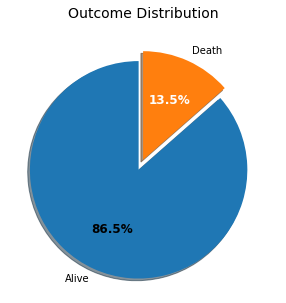

In [11]:
'''
Firstly, I would like to see the distribution of the outcome. As we can see, the distribution is
very imbalanced, which I will address later
'''
fig, ax = plt.subplots(figsize=(8,5))

patches, texts, autotexts = ax.pie(df['outcome'].value_counts(), autopct= '%1.1f%%', shadow=True, 
                                   startangle=90, explode=(0.1, 0), labels=['Alive','Death'])

plt.setp(autotexts, size=12, color = 'black', weight='bold')
autotexts[1].set_color('white');

plt.title('Outcome Distribution', fontsize=14)
plt.show()

In [12]:
fig = px.histogram(df, x="age", color="outcome", marginal="box", hover_data=df.columns)
fig.show()

We can see that most deaths are from ages 88-89, and can see that age is positively correlated with the number of deaths

In [13]:
df1 = df.dropna(subset=['BMI'])
fig = px.histogram(df1, x="BMI", color="outcome", marginal="box", hover_data=df1.columns)
fig.show()

The most number of deaths is in the range of 26-28 BMI. Meanwhile high BMI values has low number of deaths

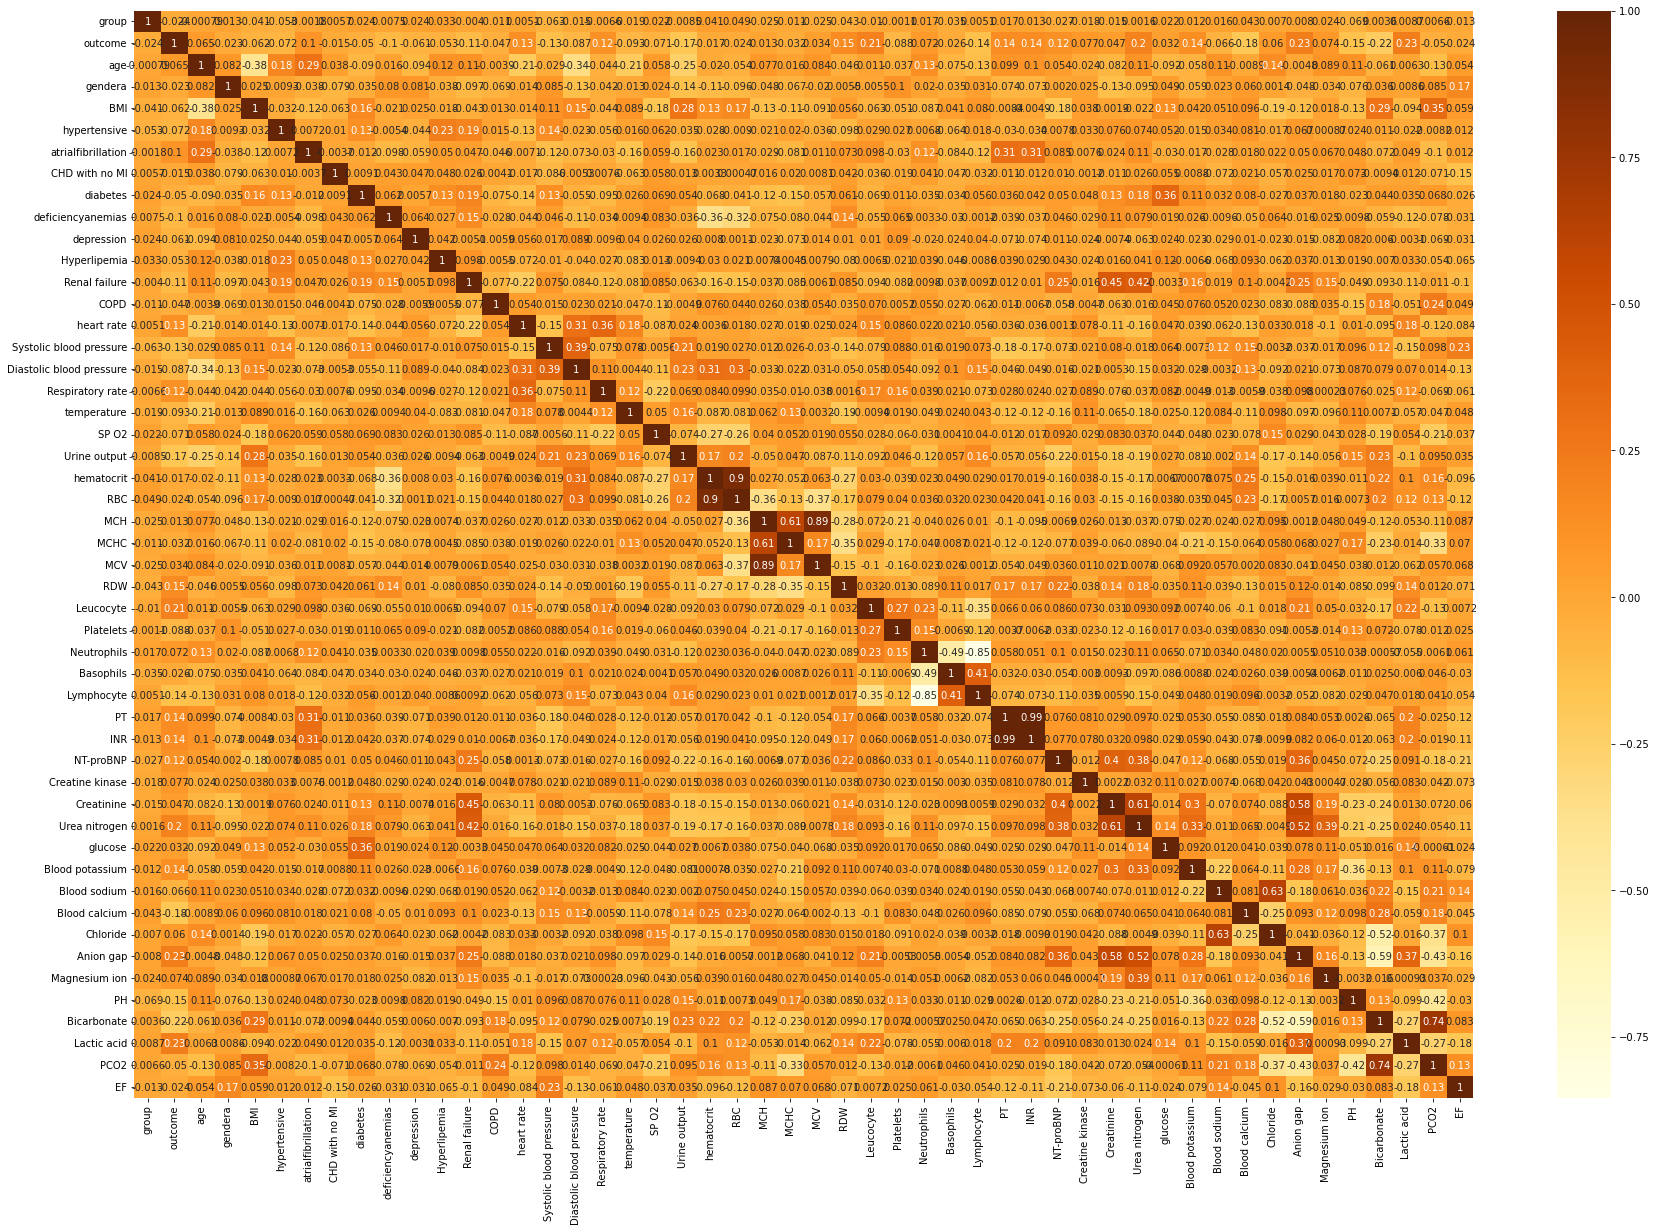

In [14]:
'''
Firstly, I would like to see each variable's correlation to each other
'''
corr = df.corr()
plt.figure(figsize=(30,20))
sns.heatmap(corr, annot=True, cmap='YlOrBr');

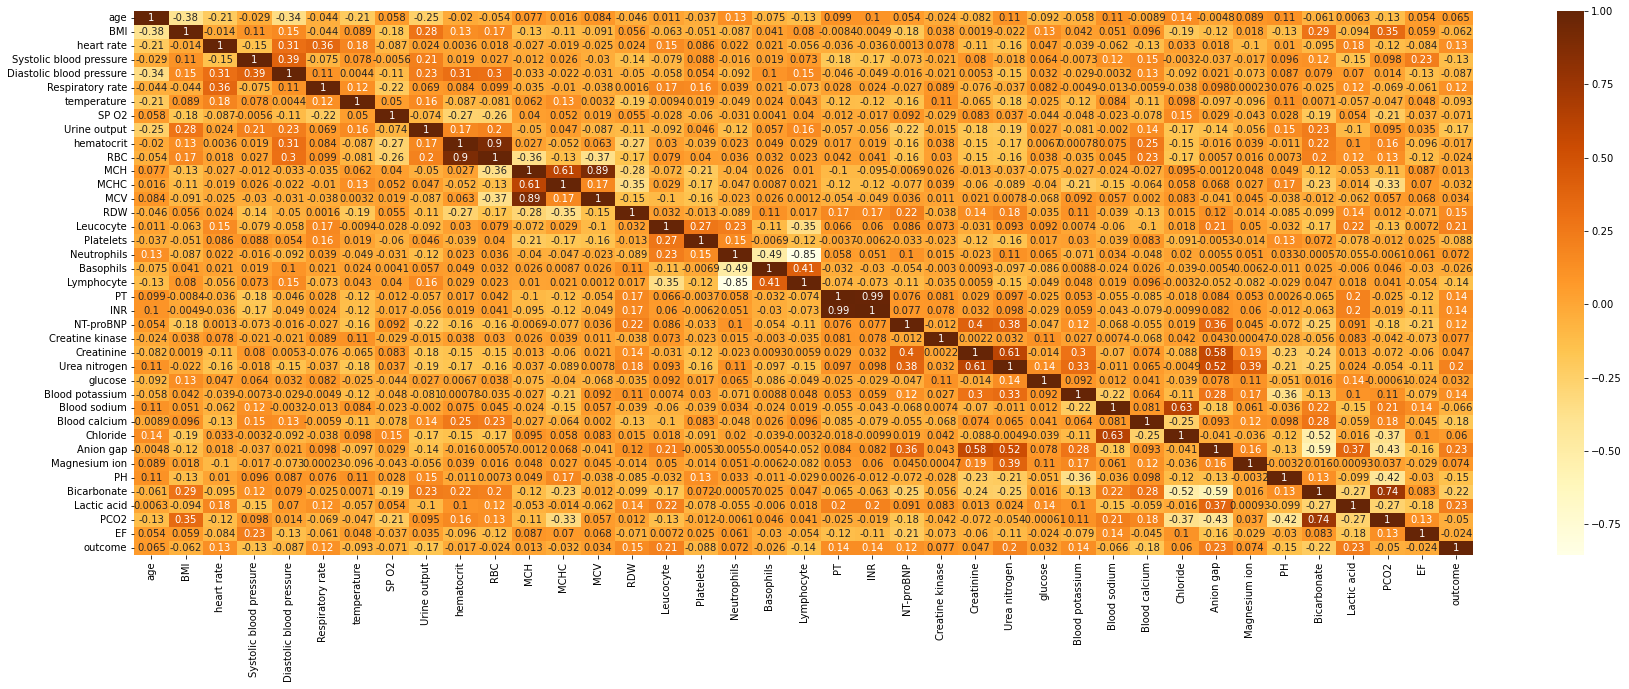

In [15]:
'''
This is to only see numerical features and the outcome's correlations
'''
cols = numerical_features + ['outcome']
corr = df[cols].corr()
plt.figure(figsize=(30,10))
sns.heatmap(corr, annot=True, cmap='YlOrBr');

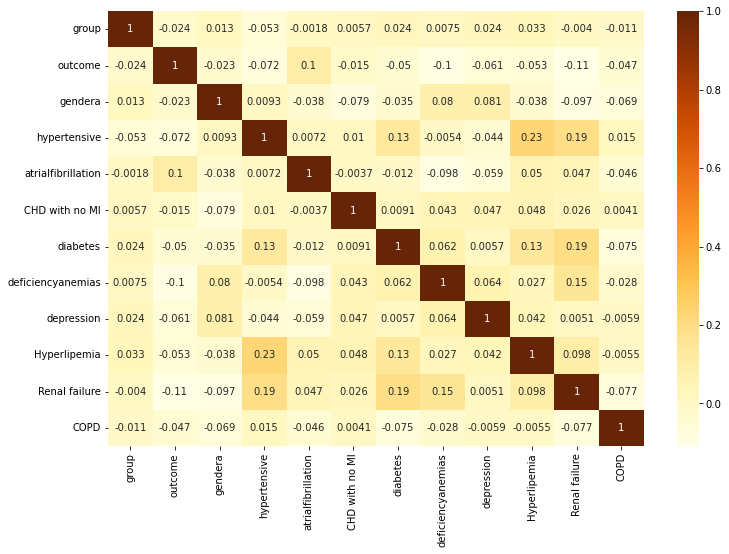

In [16]:
'''
This is to see each categorical feature's correlation to each other
'''
corr = df[categorical_features].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='YlOrBr');

We can see that there are variables which are heavily correlated to each other, namely:
1. RBC and Hematocrit
2. MCV and MCH
3. INR and PT

This could be the answers to the question "Are there correlations between variables that significantly affect mortality prediction?" so I decided to keep them first.

We can see that only numerical columns have null values, since there are around 20% null values in some columns, I decided to impute the missing values. Before deciding how to impute, I want to see the distribution of those columns first.

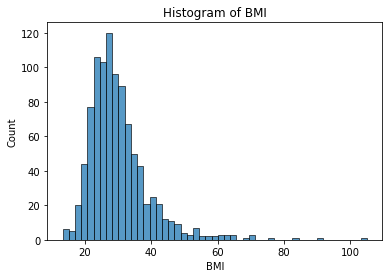

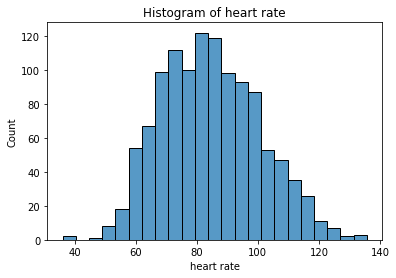

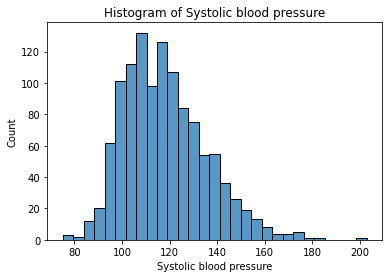

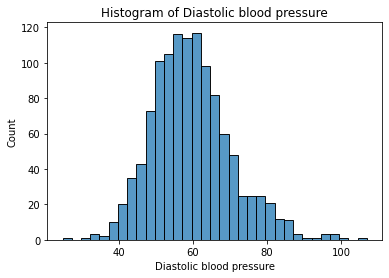

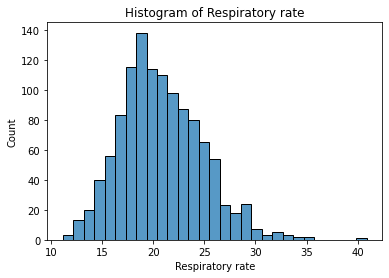

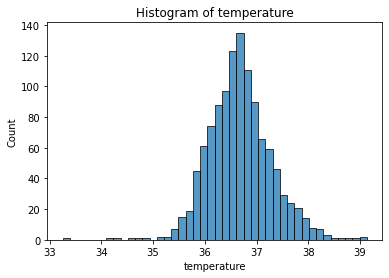

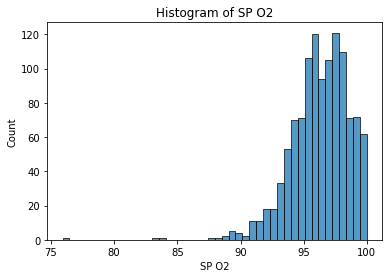

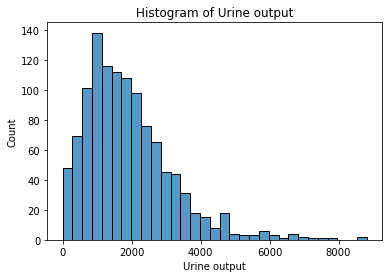

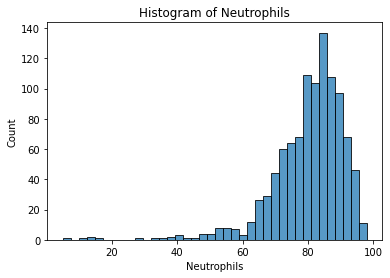

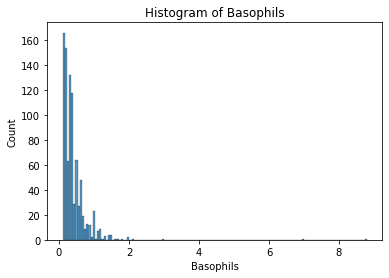

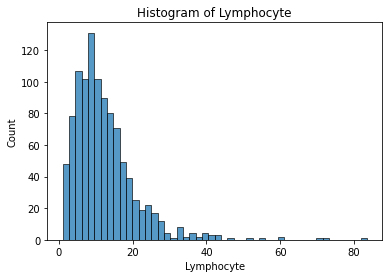

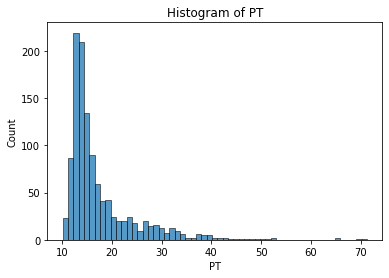

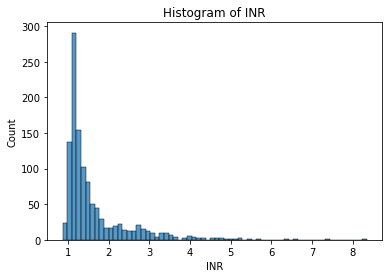

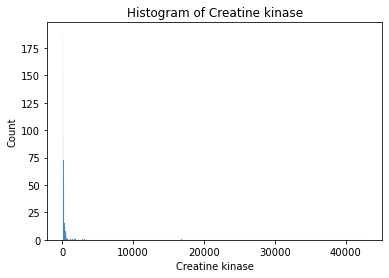

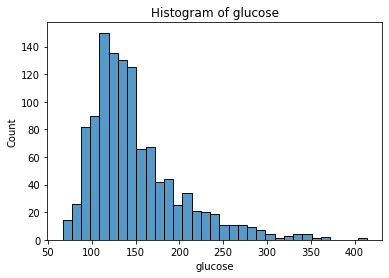

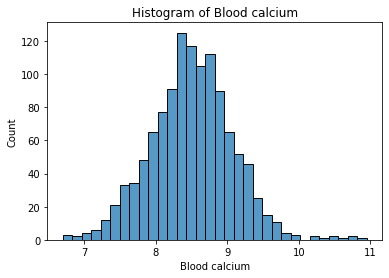

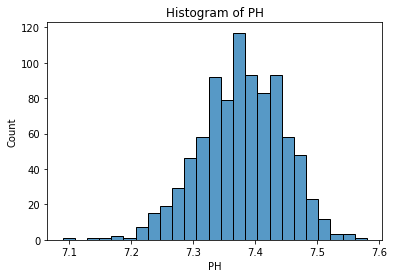

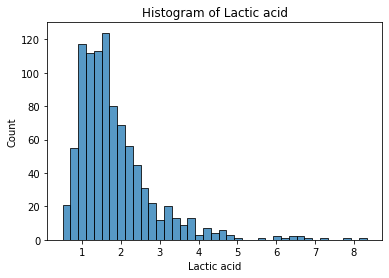

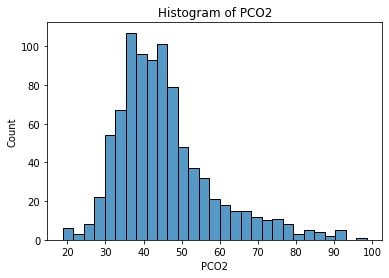

In [17]:
null_cols = df.columns[df.isnull().any()].tolist()
for column in null_cols:
    sns.histplot(data=df[column])
    plt.title(f'Histogram of {column}')
    plt.show()

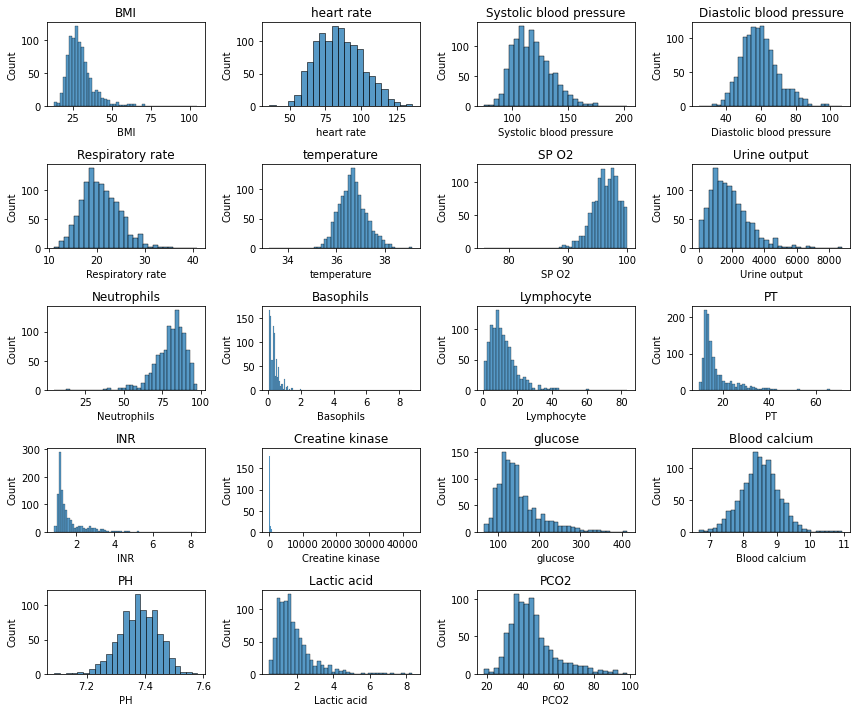

In [18]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(12, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()
num_subplots = len(null_cols)
# Iterate over the columns and plot a histogram on each subplot
for i, column in enumerate(null_cols):
    ax = axes[i]  # Get the current subplot
    
    # Plot the histogram using Seaborn
    sns.histplot(data=df, x=column, ax=ax)
    
    # Set a title for the subplot
    ax.set_title(column)
    
# Remove any unused subplots
if num_subplots < len(axes):
    for j in range(num_subplots, len(axes)):
        fig.delaxes(axes[j])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

# Data Preprocessing

Since most of them have skewed distribution, I'll impute them using the median values instead of the mean values. Next, I'll divide the data into train and test data before imputing to prevent data leakage from train data to test data.

In [19]:
x = df.drop(columns='outcome')
y = df[['outcome']]

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=123)

In [20]:
X_train.isnull().sum()

group                         0
age                           0
gendera                       0
BMI                         152
hypertensive                  0
atrialfibrillation            0
CHD with no MI                0
diabetes                      0
deficiencyanemias             0
depression                    0
Hyperlipemia                  0
Renal failure                 0
COPD                          0
heart rate                    9
Systolic blood pressure      11
Diastolic blood pressure     11
Respiratory rate              9
temperature                  13
SP O2                         9
Urine output                 27
hematocrit                    0
RBC                           0
MCH                           0
MCHC                          0
MCV                           0
RDW                           0
Leucocyte                     0
Platelets                     0
Neutrophils                 100
Basophils                   174
Lymphocyte                  100
PT      

In [21]:
X_test.isnull().sum()

group                        0
age                          0
gendera                      0
BMI                         62
hypertensive                 0
atrialfibrillation           0
CHD with no MI               0
diabetes                     0
deficiencyanemias            0
depression                   0
Hyperlipemia                 0
Renal failure                0
COPD                         0
heart rate                   3
Systolic blood pressure      4
Diastolic blood pressure     4
Respiratory rate             3
temperature                  5
SP O2                        3
Urine output                 8
hematocrit                   0
RBC                          0
MCH                          0
MCHC                         0
MCV                          0
RDW                          0
Leucocyte                    0
Platelets                    0
Neutrophils                 44
Basophils                   85
Lymphocyte                  45
PT                           4
INR     

I am using SimpleImputer from sklearn to impute the train data and use the measurements from train data to impute the test data

In [22]:
imputer = SimpleImputer(missing_values = np.nan, strategy ='median')

#fit and transform on training data
imputed_X_train = imputer.fit_transform(X_train)

#apply transform on the test data 
imputed_X_test = imputer.transform(X_test)

After imputing the data, I scaled the data

In [23]:
# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to your data and transform it
scaled_X_train = scaler.fit_transform(imputed_X_train)

scaled_X_test = scaler.transform(imputed_X_test)

It was noted that the data was highly imbalanced, I addressed this issue by applying SMOTE to over sample the data

In [24]:
# Create an instance of SMOTE
smote = SMOTE(sampling_strategy='minority')

# Apply SMOTE to the training data
resampled_X_train, resampled_y_train = smote.fit_resample(scaled_X_train, y_train)

# Model Development
Firstly, I trained different machine learning models including Logistic Regression, XGB Classifier, Decision Tree Classifier, and Random Forest classifier without any hyperparameter tuning to see how well they would perform

In [25]:
def predict_mortality(modelClass):
    model = modelClass(random_state=123)
    model.fit(resampled_X_train, resampled_y_train)
    
    print("performance on train data")
    pred = model.predict(resampled_X_train)
    print("Accuracy:",accuracy_score(resampled_y_train,pred))
    print("Precision:",precision_score(resampled_y_train,pred))
    print("Recall:",recall_score(resampled_y_train,pred))
    print("F1 score:",f1_score(resampled_y_train, pred))
    
    print("performance on test data")
    pred = model.predict(scaled_X_test)
    print("Accuracy:",accuracy_score(y_test,pred))
    print("Precision:",precision_score(y_test,pred))
    print("Recall:",recall_score(y_test,pred))
    print("F1 score:",f1_score(y_test, pred))

In [26]:
predict_mortality(LogisticRegression)

performance on train data
Accuracy: 0.8138075313807531
Precision: 0.8065395095367848
Recall: 0.8256624825662483
F1 score: 0.8159889731219849
performance on test data
Accuracy: 0.7960339943342776
Precision: 0.4
Recall: 0.7169811320754716
F1 score: 0.5135135135135135


In [27]:
predict_mortality(XGBClassifier)

[19:19:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
performance on train data
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0
performance on test data
Accuracy: 0.8470254957507082
Precision: 0.48717948717948717
Recall: 0.3584905660377358
F1 score: 0.41304347826086957


In [28]:
predict_mortality(DecisionTreeClassifier)

performance on train data
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0
performance on test data
Accuracy: 0.7988668555240793
Precision: 0.375
Recall: 0.5094339622641509
F1 score: 0.432


In [29]:
predict_mortality(RandomForestClassifier)

performance on train data
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0
performance on test data
Accuracy: 0.8611898016997167
Precision: 0.5555555555555556
Recall: 0.37735849056603776
F1 score: 0.449438202247191


Now, I am going to train XGB Classifier and Random Forest classifier using hyper parameter tuning using the hyperopt library

In [30]:
# create the search space
space_xgb ={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators':hp.uniform('n_estimators',100,500)
    }

def objective_xgb(space):
    clf=XGBClassifier(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],reg_alpha = int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), random_state=123)
    
    evaluation = [( resampled_X_train, resampled_y_train), ( scaled_X_test, y_test)]
    
    clf.fit(resampled_X_train, resampled_y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(scaled_X_test)
    f1 = f1_score(y_test, pred)
    print ("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK, 'model':clf }

In [31]:
trials_xgb = Trials()

best_hyperparams_xgb = fmin(fn = objective_xgb,
                        space = space_xgb,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials_xgb)

SCORE:                                                                                                                 
0.0                                                                                                                    
SCORE:                                                                                                                 
0.0                                                                                                                    
SCORE:                                                                                                                 
0.0                                                                                                                    
SCORE:                                                                                                                 
0.0                                                                                                                    
SCORE:                                  

SCORE:                                                                                                                 
0.45751633986928103                                                                                                    
SCORE:                                                                                                                 
0.0                                                                                                                    
SCORE:                                                                                                                 
0.422360248447205                                                                                                      
SCORE:                                                                                                                 
0.0                                                                                                                    
SCORE:                                  

SCORE:                                                                                                                 
0.3878787878787879                                                                                                     
SCORE:                                                                                                                 
0.430379746835443                                                                                                      
SCORE:                                                                                                                 
0.3230769230769231                                                                                                     
SCORE:                                                                                                                 
0.0                                                                                                                    
SCORE:                                  

In [33]:
xgb=XGBClassifier(n_estimators = int(best_hyperparams_xgb['n_estimators']), 
                  max_depth = int(best_hyperparams_xgb['max_depth']), 
                  gamma = best_hyperparams_xgb['gamma'],
                  reg_alpha = int(best_hyperparams_xgb['reg_alpha']),
                  min_child_weight=int(best_hyperparams_xgb['min_child_weight']),
                  colsample_bytree=int(best_hyperparams_xgb['colsample_bytree']), random_state=123)
    
evaluation = [( resampled_X_train, resampled_y_train), ( scaled_X_test, y_test)]

xgb.fit(resampled_X_train, resampled_y_train,
        eval_set=evaluation, eval_metric="auc",
        early_stopping_rounds=10,verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0, enable_categorical=False,
              gamma=7.817357251571705, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=14, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=275, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=44, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

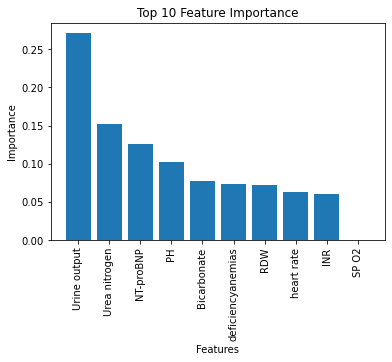

In [34]:
feature_importance = xgb.feature_importances_
feature_names = X_train.columns

# Sort the feature importance scores and get the top 10
sorted_indices = feature_importance.argsort()[::-1][:10]
sorted_features = feature_names[sorted_indices]
sorted_scores = feature_importance[sorted_indices]

# Plot feature importance
plt.bar(sorted_features, sorted_scores)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Top 10 Feature Importance")
plt.xticks(rotation='vertical')
plt.show()

Random Forest

In [35]:
# Create the search space
space_rfc = {'n_estimators':hp.uniform('n_estimators',100,500),
               'max_depth': hp.uniform("max_depth",5,20),
               'min_samples_split': hp.uniform('min_samples_split',2,6),
               'min_samples_leaf': hp.uniform('min_samples_leaf',1,5)}

def objective_rfc(space):
    clf=RandomForestClassifier(
                    n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']),
                    min_samples_split = int(space['min_samples_split']),
                    min_samples_leaf=int(space['min_samples_leaf']),random_state=123)
    
    clf.fit(resampled_X_train, resampled_y_train)

    pred = clf.predict(scaled_X_test)
    f1 = f1_score(y_test, pred)
    print ("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK, 'model':clf }

In [36]:
trials_rfc = Trials()

best_hyperparams_rfc = fmin(fn = objective_rfc,
                        space = space_rfc,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials_rfc)

SCORE:                                                                                                                 
0.45161290322580644                                                                                                    
SCORE:                                                                                                                 
0.4444444444444445                                                                                                     
SCORE:                                                                                                                 
0.48648648648648646                                                                                                    
SCORE:                                                                                                                 
0.43010752688172044                                                                                                    
SCORE:                                  

SCORE:                                                                                                                 
0.4897959183673469                                                                                                     
SCORE:                                                                                                                 
0.5                                                                                                                    
SCORE:                                                                                                                 
0.5043478260869565                                                                                                     
SCORE:                                                                                                                 
0.44680851063829785                                                                                                    
SCORE:                                  

SCORE:                                                                                                                 
0.48648648648648646                                                                                                    
SCORE:                                                                                                                 
0.4666666666666667                                                                                                     
SCORE:                                                                                                                 
0.4666666666666667                                                                                                     
SCORE:                                                                                                                 
0.5192307692307693                                                                                                     
SCORE:                                  

In [38]:
rfc=RandomForestClassifier(n_estimators =int(best_hyperparams_rfc['n_estimators']), 
                    max_depth = int(best_hyperparams_rfc['max_depth']),
                    min_samples_split = int(best_hyperparams_rfc['min_samples_split']),
                    min_samples_leaf=int(best_hyperparams_rfc['min_samples_leaf']),random_state=123)
    
rfc.fit(resampled_X_train, resampled_y_train)

0.5192307692307693

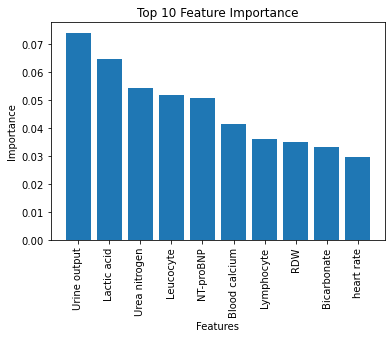

In [40]:
feature_importance = rfc.feature_importances_
feature_names = X_train.columns

# Sort the feature importance scores and get the top 10
sorted_indices = feature_importance.argsort()[::-1][:10]
sorted_features = feature_names[sorted_indices]
sorted_scores = feature_importance[sorted_indices]

# Plot feature importance
plt.bar(sorted_features, sorted_scores)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Top 10 Feature Importance")
plt.xticks(rotation='vertical')
plt.show()

In [41]:
df[sorted_features].corr()

Urine output  Lactic acid  Urea nitrogen  Leucocyte  NT-proBNP  \
Urine output           1.00        -0.10          -0.19      -0.09      -0.22   
Lactic acid           -0.10         1.00           0.02       0.22       0.09   
Urea nitrogen         -0.19         0.02           1.00       0.09       0.38   
Leucocyte             -0.09         0.22           0.09       1.00       0.09   
NT-proBNP             -0.22         0.09           0.38       0.09       1.00   
Blood calcium          0.14        -0.06           0.06      -0.10      -0.06   
Lymphocyte             0.16         0.02          -0.15      -0.35      -0.11   
RDW                   -0.11         0.14           0.18       0.03       0.22   
Bicarbonate            0.23        -0.27          -0.25      -0.17      -0.25   
heart rate             0.02         0.18          -0.16       0.15       0.00   

               Blood calcium  Lymphocyte   RDW  Bicarbonate  heart rate  
Urine output            0.14        0.16 -0.11         0.23        0.02  
Lactic acid            -0.06        0.02  0.14        -0.27        0.18  
Urea nitrogen           0.06       -0.15  0.18        -0.25       -0.16  
Leucocyte              -0.10       -0.35  0.03        -0.17        0.15  
NT-proBNP              -0.06       -0.11  0.22        -0.25        0.00  
Blood calcium           1.00        0.10 -0.13         0.28       -0.13  
Lymphocyte              0.10        1.00  0.02         0.05       -0.06  
RDW                    -0.13        0.02  1.00        -0.10        0.02  
Bicarbonate             0.28        0.05 -0.10         1.00       -0.09  
heart rate             -0.13       -0.06  0.02        -0.09        1.00

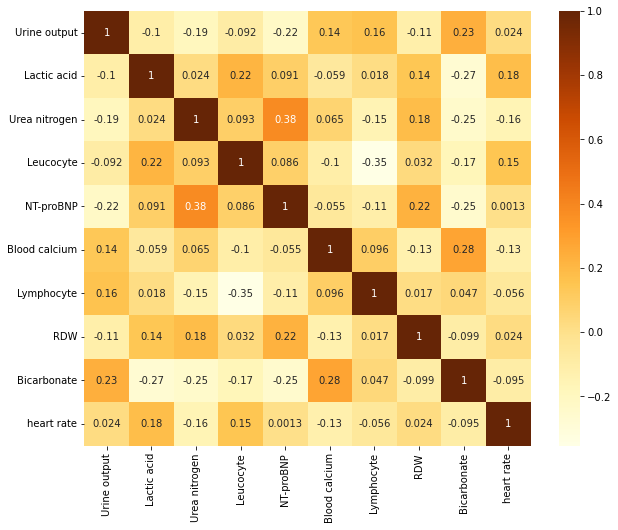

In [42]:
corr = df[sorted_features].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='YlOrBr');

I chose Random Forest Classifier as the model to predict mortality as it showed the best performance in terms of F1 score among the models I tried. It is suitable for the data as it can handle both continuous and categorical variables, its robustness to outliers and noise, it can handle a large amount of features, and handle non-linear relationship. This model has an F1 score of 0.519 on the test set.

From the features used in the random forest, the 10 most significant predictors of mortality are:

 >Urine output, Lactic acid, Urea nitrogen, Leucocyte, NT-proBNP, Blood calcium, Lmphocyte, RDW, Bicarbonate, and heart rate

We can see some medium correlations between them namely:
1. NT-proBNP and Urea Nitrogen
2. Lycocyte and Lymphocyte
3. NT-proBNP and Bicarbonate
4. Blood calcium and Bicarbonate
5. Bicarbonate and Urine output